# Stock Price Prediction Model

## Dependencies

### Library Installation (if needed)

In [168]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import requests
import warnings
import simfin as sf
from methods.model_methods import *
from datetime import datetime
from tqdm import tqdm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

/home/victorvj/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from simfin.names import *

# Set your API-key for downloading data.
# Replace YOUR_API_KEY with your actual API-key.
sf.set_api_key("01dc27f7-2bfd-4092-897c-6e0ac00bd480")

# Set the local directory where data-files are stored.
# The dir will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

# Load the annual Income Statements for all companies in the US.
# The data is automatically downloaded if you don't have it already.
df = sf.load_balance(variant='quarterly', market='us')

Dataset "us-balance-quarterly" on disk (0 days old).
- Loading from disk ... Done!


In [19]:
df_cash = sf.load_cashflow(variant='quarterly', market='us')
df_cash = df_cash.loc["LLY"]
df_cash

Dataset "us-cashflow-quarterly" on disk (0 days old).
- Loading from disk ... Done!


,SimFinId,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),Net Income/Starting Line,Depreciation & Amortization,...,Net Cash from Operating Activities,Change in Fixed Assets & Intangibles,Net Change in Long Term Investment,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash
Report Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,378181,USD,2019,Q4,2020-02-19,2020-10-28,9.096360e+08,9.156360e+08,1.495700e+09,340700000.0,...,1963700000,-3.265000e+08,60600000.0,0.000000e+00,-4.140000e+07,-5.872000e+08,-2.215000e+08,-3.000000e+08,-1.113600e+09,773700000
2020-03-31,378181,USD,2020,Q1,2020-05-01,2021-04-30,9.082000e+08,9.117000e+08,1.456500e+09,273600000.0,...,382400000,-2.583000e+08,-28500000.0,-8.493000e+08,-1.060900e+09,-6.713000e+08,1.472400e+09,-5.000000e+08,1.067000e+08,-638500000
2020-06-30,378181,USD,2020,Q2,2020-07-31,2021-04-30,9.072000e+08,9.109000e+08,1.412000e+09,324400000.0,...,2495400000,-2.818000e+08,-126300000.0,0.000000e+00,-2.104000e+08,-6.742000e+08,-9.955000e+08,0.000000e+00,-1.673200e+09,666099999
2020-09-30,378181,USD,2020,Q3,2020-10-28,2021-08-03,9.072000e+08,9.114000e+08,1.208400e+09,358400000.0,...,1806600000,-3.931000e+08,505200000.0,0.000000e+00,-3.135000e+08,-6.716000e+08,3.948000e+08,0.000000e+00,-2.791000e+08,1230200001
2020-12-31,378181,USD,2020,Q4,2021-02-17,2021-10-27,9.079360e+08,9.160200e+08,2.116800e+09,367500000.0,...,1815200000,-4.547000e+08,48000000.0,0.000000e+00,-6.741000e+08,-6.700000e+08,-5.801000e+08,0.000000e+00,-1.291500e+09,61800000
2021-03-31,378181,USD,2021,Q1,2021-04-30,2022-04-29,9.088000e+08,9.124000e+08,1.355300e+09,350300000.0,...,1697400000,-3.003000e+08,-6700000.0,-7.474000e+08,-1.283500e+09,-7.748000e+08,-3.700000e+06,NaN,-1.058400e+09,-654700000
2021-06-30,378181,USD,2021,Q2,2021-08-03,2022-04-29,9.088000e+08,9.124000e+08,1.390200e+09,369300000.0,...,1775500000,-3.813000e+08,-34500000.0,0.000000e+00,-4.833000e+08,-7.683000e+08,2.000000e+08,-5.000000e+08,-1.083200e+09,217600000
2021-09-30,378181,USD,2021,Q3,2021-10-27,2022-08-04,9.565890e+08,9.565890e+08,1.110100e+09,382300000.0,...,1631300000,-3.368000e+08,-131700000.0,0.000000e+00,-6.165000e+08,-7.704000e+08,3.077000e+08,0.000000e+00,-4.632000e+08,568200000
2021-12-31,378181,USD,2021,Q4,2022-02-23,2022-11-01,9.565890e+08,9.565890e+08,1.726100e+09,445700000.0,...,2261700000,-7.540000e+07,43000000.0,0.000000e+00,-4.842000e+08,-7.733000e+08,-2.600000e+06,-7.500000e+08,-1.526500e+09,30300000


In [37]:
df_balance = sf.load_balance(variant='quarterly', market='us')
df_balance = df_balance.loc["LLY"]
df_balance

Dataset "us-balance-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Done!


Dataset "us-balance-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Done!


,SimFinId,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,...,Short Term Debt,Total Current Liabilities,Long Term Debt,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity
Report Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,378181,USD,2019,Q4,2020-02-19,2021-02-17,9.096360e+08,9.156360e+08,2.438500e+09,4.547300e+09,...,1.499300e+09,1.177520e+10,1.381790e+10,2.481180e+10,3.658700e+10,4.270900e+09,-60800000.0,4.920400e+09,2.699100e+09,39286100000
2020-03-31,378181,USD,2020,Q1,2020-05-01,2020-05-01,9.082000e+08,9.117000e+08,1.777400e+09,5.106100e+09,...,3.248000e+09,1.261020e+10,1.398230e+10,2.529540e+10,3.790560e+10,4.141000e+09,-55700000.0,5.879400e+09,3.197200e+09,41102800000
2020-06-30,378181,USD,2020,Q2,2020-07-31,2020-07-31,9.072000e+08,9.109000e+08,2.387900e+09,4.828900e+09,...,1.263800e+09,1.198850e+10,1.506440e+10,2.570650e+10,3.769500e+10,4.214300e+09,-55700000.0,6.617200e+09,4.272000e+09,41967000000
2020-09-30,378181,USD,2020,Q3,2020-10-28,2020-10-28,9.072000e+08,9.114000e+08,3.630300e+09,4.886700e+09,...,5.875000e+08,1.197690e+10,1.633460e+10,2.697310e+10,3.895000e+10,4.283700e+09,-55700000.0,7.154000e+09,4.996000e+09,43945999999
2020-12-31,378181,USD,2020,Q4,2021-02-17,2022-02-23,9.079360e+08,9.160200e+08,3.681300e+09,5.875300e+09,...,8.700000e+06,1.248160e+10,1.658660e+10,2.832630e+10,4.080790e+10,4.363500e+09,-55700000.0,7.830200e+09,5.825200e+09,46633099999
2021-03-31,378181,USD,2021,Q1,2021-04-30,2021-04-30,9.088000e+08,9.124000e+08,3.051400e+09,5.592800e+09,...,4.900000e+06,1.171420e+10,1.619960e+10,2.802480e+10,3.973900e+10,4.165700e+09,-52700000.0,9.181300e+09,7.099300e+09,46838300000
2021-06-30,378181,USD,2021,Q2,2021-08-03,2021-08-03,9.088000e+08,9.124000e+08,3.271200e+09,5.829400e+09,...,1.778500e+09,1.509320e+10,1.473660e+10,2.605230e+10,4.114550e+10,4.254100e+09,-52700000.0,8.530100e+09,6.663500e+09,47809000000
2021-09-30,378181,USD,2021,Q3,2021-10-27,2021-10-27,9.565890e+08,9.565890e+08,3.825300e+09,5.914300e+09,...,1.563000e+09,1.368200e+10,1.552240e+10,2.655090e+10,4.023290e+10,4.343000e+09,-52700000.0,9.639400e+09,7.954100e+09,48187000000
2021-12-31,378181,USD,2021,Q4,2022-02-23,2023-02-22,9.565890e+08,9.565890e+08,3.908600e+09,6.672800e+09,...,1.538300e+09,1.505270e+10,1.534640e+10,2.459850e+10,3.965120e+10,7.429700e+09,-52700000.0,8.958500e+09,9.154800e+09,48806000000


In [40]:
print(df.columns)

Index(['Report Date', 'SimFinId', 'Currency', 'Fiscal Year', 'Fiscal Period',
       'Publish Date', 'Restated Date', 'Shares (Basic)', 'Shares (Diluted)',
       'Net Income/Starting Line', 'Depreciation & Amortization',
       'Non-Cash Items', 'Change in Working Capital',
       'Change in Accounts Receivable', 'Change in Inventories',
       'Change in Accounts Payable', 'Change in Other',
       'Net Cash from Operating Activities',
       'Change in Fixed Assets & Intangibles',
       'Net Change in Long Term Investment',
       'Net Cash from Acquisitions & Divestitures',
       'Net Cash from Investing Activities', 'Dividends Paid',
       'Cash from (Repayment of) Debt', 'Cash from (Repurchase of) Equity',
       'Net Cash from Financing Activities', 'Net Change in Cash',
       'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term Investments 

### Variables

In [170]:
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    build_new_dataset = False
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6
outlier = 3
train_new_model = {'True': True, 'False': False}.get(input('Train new models? (Bool)'))
debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))

In [171]:
symbols = pd.read_csv('../data/tickers/simple_tickers.csv')['Ticker'].tolist()
if symbol_list == 'filtered':
    symbols = symbols + pd.read_csv('../data/tickers/model_filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = symbols + pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = symbols + pd.read_csv("../data/tickers/model_filtered_tickers.csv")["Ticker"].tolist()
    symbols = symbols + np.random.choice(all_symbols, num_symbols, replace=False).tolist()
symbols = pd.Series(symbols).unique()

## Data Preparation

#### Test load

In [172]:
test_stock = Stock("MSFT").get_df_financials()
if debugging:
    display(test_stock)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,Receivables,AccountsReceivable,AllowanceForDoubtfulAccountsReceivable,GrossAccountsReceivable,CashCashEquivalentsAndShortTermInvestments,OtherShortTermInvestments,CashAndCashEquivalents,CashEquivalents,CashFinancial,FinancialAssetsDesignatedasFairValueThroughProfitorLossTotal
0,MSFT,Microsoft Corporation,2025-03-31,0,Technology,Software - Infrastructure,374.087158,NaN,69660000.0,0.180,...,5.170000e+10,5.170000e+10,-695000000.0,5.239500e+10,7.961200e+10,5.078400e+10,2.882800e+10,1.814800e+10,1.068000e+10,NaN
1,MSFT,Microsoft Corporation,2024-12-31,1,Technology,Software - Infrastructure,419.196564,-0.091444,-203220000.0,0.180,...,4.818800e+10,4.818800e+10,-662000000.0,4.885000e+10,7.155100e+10,5.406900e+10,1.748200e+10,7.835000e+09,9.647000e+09,NaN
2,MSFT,Microsoft Corporation,2024-09-30,2,Technology,Software - Infrastructure,427.093567,-0.010736,57190000.0,0.190,...,4.414800e+10,4.414800e+10,-647000000.0,4.479500e+10,7.842900e+10,5.758900e+10,2.084000e+10,1.025200e+10,1.058800e+10,NaN
3,MSFT,Microsoft Corporation,2024-06-30,3,Technology,Software - Infrastructure,442.821350,-0.040628,-99918000.0,0.182,...,5.692400e+10,5.692400e+10,-830000000.0,5.775400e+10,7.553100e+10,5.721600e+10,1.831500e+10,6.744000e+09,1.157100e+10,NaN
5,MSFT,Microsoft Corporation,2023-06-30,5,Technology,Software - Infrastructure,334.775513,-0.070833,-2850000.0,0.190,...,4.868800e+10,4.868800e+10,-650000000.0,4.933800e+10,1.112560e+11,7.655200e+10,3.470400e+10,2.622600e+10,8.478000e+09,NaN
6,MSFT,Microsoft Corporation,2022-06-30,6,Technology,Software - Infrastructure,250.065262,-0.073301,43754000.0,0.131,...,4.426100e+10,4.426100e+10,-633000000.0,4.489400e+10,1.047490e+11,9.081800e+10,1.393100e+10,5.673000e+09,8.258000e+09,NaN


#### Download annual financial data

In [173]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv("../data/tickers/model_filtered_tickers.csv")
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        stock = Stock(symbol)
        try:
            ticker_df = Stock(symbol).get_df_financials()
            if ticker_df.isna().sum().sum() < round(test_stock.shape[1] * minimum_feature_threshold):
                if symbol not in filtered_pd["Ticker"].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{"Ticker": symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(["Ticker", "Name", "Date", "3M Future Change", "Sector", "Industry"]):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd["Ticker"].tolist():
                    filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                    if debugging:
                        print(f"Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(test_stock.shape[1] * minimum_feature_threshold)}")
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd["Ticker"].tolist():
                filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                if debugging:
                    print(f"Removed {symbol} from filtered tickers because an exception was raised \n {error}")
            else:
                if debugging:
                    print(f"{symbol}: exception raised: {error}")
            continue
    filtered_pd.to_csv("../data/tickers/model_filtered_tickers.csv", index=False)
    df.to_csv("../data/model_results/earnings_data.csv", index=False)
else:
    df = pd.read_csv("../data/model_results/earnings_data.csv")

### Short visualisation

In [174]:
if debugging:
    display(df)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,LiabilitiesHeldforSaleNonCurrent,DuetoRelatedPartiesNonCurrent,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes
0,BAESY,BAE Systems PLC,2024-12-31,1.0,Industrials,Aerospace & Defense,56.118683,0.451540,-2.520000e+06,0.180000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAESY,BAE Systems PLC,2023-12-31,3.0,Industrials,Aerospace & Defense,54.674278,0.216240,-5.567000e+07,0.190000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAESY,BAE Systems PLC,2022-12-31,4.0,Industrials,Aerospace & Defense,39.349594,0.171293,7.744344e+07,0.158371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAESY,BAE Systems PLC,2021-12-31,5.0,Industrials,Aerospace & Defense,26.875683,0.257805,2.160000e+07,0.180000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LLY,Eli Lilly and Company,2025-03-31,0.0,Healthcare,Drug Manufacturers - General,822.414185,NaN,-3.541868e+08,0.202000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347,FM.TO,FIRST QUANTUM MINERALS LTD,2024-09-30,2.0,Basic Materials,Copper,18.440001,0.010846,-4.050000e+06,0.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4348,FM.TO,FIRST QUANTUM MINERALS LTD,2024-06-30,3.0,Basic Materials,Copper,17.969999,0.054535,-1.095000e+07,0.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4349,FM.TO,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,Basic Materials,Copper,11.050000,0.317647,-4.064000e+08,0.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4350,FM.TO,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,Basic Materials,Copper,28.116659,0.098268,4.048000e+07,0.220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [175]:
imputer = SimpleImputer()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    df[column] = imputer.fit_transform(df[[column]])

le = LabelEncoder()
for column in ["Ticker", "Sector", "Industry"]:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Feature engineering

/tmp/ipykernel_43894/872096102.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["PE"] = df["Price"]/(df["BasicEPS"])


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,DuetoRelatedPartiesNonCurrent,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,PE
0,56,BAE Systems PLC,2024-12-31,1.0,7,1,56.118683,0.451540,-2.520000e+06,0.180000,...,4.906936e+07,8.944741e+09,1.336929e+09,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,21.617366
1,56,BAE Systems PLC,2023-12-31,3.0,7,1,54.674278,0.216240,-5.567000e+07,0.190000,...,4.906936e+07,8.944741e+09,1.336929e+09,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,22.297830
2,56,BAE Systems PLC,2022-12-31,4.0,7,1,39.349594,0.171293,7.744344e+07,0.158371,...,4.906936e+07,8.944741e+09,1.336929e+09,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,19.251269
3,56,BAE Systems PLC,2021-12-31,5.0,7,1,26.875683,0.257805,2.160000e+07,0.180000,...,4.906936e+07,8.944741e+09,1.336929e+09,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,12.171958
4,422,Eli Lilly and Company,2025-03-31,0.0,6,29,822.414185,NaN,-3.541868e+08,0.202000,...,4.906936e+07,8.944741e+09,1.336929e+09,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,267.570020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347,262,FIRST QUANTUM MINERALS LTD,2024-09-30,2.0,0,25,18.440001,0.010846,-4.050000e+06,0.150000,...,4.906936e+07,8.944741e+09,1.336929e+09,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,141.846158
4348,262,FIRST QUANTUM MINERALS LTD,2024-06-30,3.0,0,25,17.969999,0.054535,-1.095000e+07,0.150000,...,4.906936e+07,8.944741e+09,1.336929e+09,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,-299.499989
4349,262,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,0,25,11.050000,0.317647,-4.064000e+08,0.400000,...,4.906936e+07,8.944741e+09,1.336929e+09,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,-8.007247
4350,262,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,0,25,28.116659,0.098268,4.048000e+07,0.220000,...,4.906936e+07,8.944741e+09,1.336929e+09,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,18.744439


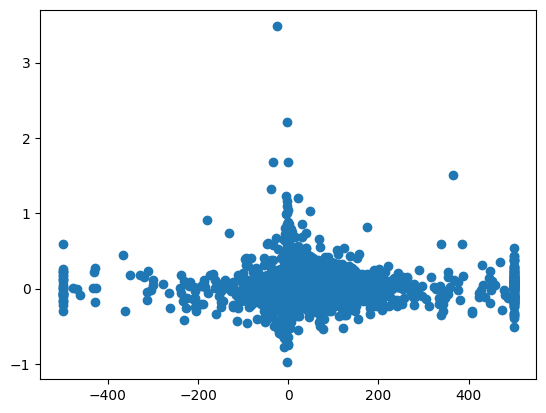

In [176]:
df["PE"] = df["Price"]/(df["BasicEPS"])
pe_limit = 500
df["PE"] = df["PE"].apply(lambda x: pe_limit if x > pe_limit else x)
df["PE"] = df["PE"].apply(lambda x: -pe_limit if x < -pe_limit else x)
if debugging:
    display(df)
    plt.scatter(df["PE"].to_list(), df["3M Future Change"].to_list())
    plt.show()

### Scaling

In [177]:
scaler = StandardScaler()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

### Splitting

In [178]:
pred_data = df.loc[df["Earn Index"] == 0].copy()
test_data  = df.loc[df["Earn Index"] == 1].copy()
train_data = df.loc[~df["Earn Index"].isin([0, 1])].copy()

pred_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

if debugging:
    print('Prediction Data:')
    display(pred_data)
    print("Test Data:")
    display(test_data)
    print('Training Data:')
    display(train_data)

Prediction Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,DuetoRelatedPartiesNonCurrent,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,PE
0,422,Eli Lilly and Company,2025-03-31,0.0,6,29,822.414185,NaN,-2.743284,0.165382,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,1.820095
1,169,Danske Bank A/S,2025-03-31,0.0,5,11,225.100006,NaN,0.084594,0.609182,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.092807
2,396,Jyske Bank A/S,2025-06-30,0.0,5,11,641.000000,NaN,0.084594,0.813252,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.097735
3,508,"Netflix, Inc.",2025-06-30,0.0,1,34,1339.130005,NaN,0.084594,-0.522508,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,1.124981
4,671,Scandinavian Tobacco Group A/S,2025-03-31,0.0,3,104,91.503189,NaN,-0.043583,0.476042,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,0.705873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,117,CWLTH BANK FPO [CBA],2025-06-30,0.0,5,10,181.941757,NaN,-1.240646,1.297072,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.113611
491,745,WORLDLINE,2025-06-30,0.0,9,95,3.585000,NaN,-0.940213,0.720132,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.379344
492,402,Kinnevik AB ser. B,2025-06-30,0.0,5,6,83.680000,NaN,0.084594,-2.075807,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.056956
493,740,WASTE CONNECTIONS INC,2025-06-30,0.0,7,111,253.423737,NaN,0.076422,0.742322,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,1.483846


Test Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,DuetoRelatedPartiesNonCurrent,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,PE
0,56,BAE Systems PLC,2024-12-31,1.0,7,1,56.118683,0.451540,0.064474,-0.078708,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.182415
1,422,Eli Lilly and Company,2024-12-31,1.0,6,29,767.409790,0.044842,-5.435903,-0.245133,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,0.171130
2,169,Danske Bank A/S,2024-12-31,1.0,5,11,191.397659,0.176085,0.026390,0.620277,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.302566
3,112,Carlsberg B A/S,2024-12-31,1.0,3,12,669.612610,0.309414,-0.705836,0.121002,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.279063
4,396,Jyske Bank A/S,2025-03-31,1.0,5,11,551.000000,0.163339,0.084594,0.797797,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.126936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,402,Kinnevik AB ser. B,2025-03-31,1.0,5,6,70.440002,0.187961,0.084594,-2.075807,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.410748
641,428,LONDON STOCK EXCHANGE GROUP PLC,2024-12-31,1.0,5,37,11283.538086,0.027027,-0.232089,0.897652,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,3.712506
642,272,FRESNILLO PLC ORD USD0.50,2024-12-31,1.0,0,71,621.149841,0.533387,-0.280740,1.252692,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,3.712506
643,740,WASTE CONNECTIONS INC,2025-03-31,1.0,7,111,278.991486,-0.091643,0.072871,0.453852,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,2.058077


Training Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,DuetoRelatedPartiesNonCurrent,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,PE
0,56,BAE Systems PLC,2023-12-31,3.0,7,1,54.674278,0.216240,-0.359883,0.032242,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.176875
1,56,BAE Systems PLC,2022-12-31,4.0,7,1,39.349594,0.171293,0.702914,-0.318681,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.201679
2,56,BAE Systems PLC,2021-12-31,5.0,7,1,26.875683,0.257805,0.257052,-0.078708,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.259318
3,422,Eli Lilly and Company,2024-09-30,2.0,6,29,879.216187,-0.125086,-8.598070,2.240146,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,3.712506
4,422,Eli Lilly and Company,2024-06-30,3.0,6,29,897.254944,-0.029119,-0.848636,-0.340206,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,1.858574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,262,FIRST QUANTUM MINERALS LTD,2024-09-30,2.0,0,25,18.440001,0.010846,0.052258,-0.411558,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,0.796470
3208,262,FIRST QUANTUM MINERALS LTD,2024-06-30,3.0,0,25,17.969999,0.054535,-0.002832,-0.411558,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-2.796905
3209,262,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,0,25,11.050000,0.317647,-3.160162,2.362191,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.423614
3210,262,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,0,25,28.116659,0.098268,0.407792,0.365092,...,-6.473209e-16,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.205806


### Labeling

In [179]:
training_columns = ["Ticker", "Earn Index", "Sector", "Industry", "PE"]
label_columns = ["3M Future Change"]
X_pred = pred_data[training_columns]
X_test = test_data[training_columns]
y_test = test_data[label_columns]
X_train = train_data[training_columns]
y_train = train_data[label_columns]
if debugging:
    print("X_pred:")
    display(X_pred)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)

X_pred:


,Ticker,Earn Index,Sector,Industry,PE
0,422,0.0,6,29,1.820095
1,169,0.0,5,11,-0.092807
2,396,0.0,5,11,-0.097735
3,508,0.0,1,34,1.124981
4,671,0.0,3,104,0.705873
...,...,...,...,...,...
490,117,0.0,5,10,-0.113611
491,745,0.0,9,95,-0.379344
492,402,0.0,5,6,-0.056956
493,740,0.0,7,111,1.483846


X_test:


,Ticker,Earn Index,Sector,Industry,PE
0,56,1.0,7,1,-0.182415
1,422,1.0,6,29,0.171130
2,169,1.0,5,11,-0.302566
3,112,1.0,3,12,-0.279063
4,396,1.0,5,11,-0.126936
...,...,...,...,...,...
640,402,1.0,5,6,-0.410748
641,428,1.0,5,37,3.712506
642,272,1.0,0,71,3.712506
643,740,1.0,7,111,2.058077


y_test:


,3M Future Change
0,0.451540
1,0.044842
2,0.176085
3,0.309414
4,0.163339
...,...
640,0.187961
641,0.027027
642,0.533387
643,-0.091643


X_train:


,Ticker,Earn Index,Sector,Industry,PE
0,56,3.0,7,1,-0.176875
1,56,4.0,7,1,-0.201679
2,56,5.0,7,1,-0.259318
3,422,2.0,6,29,3.712506
4,422,3.0,6,29,1.858574
...,...,...,...,...,...
3207,262,2.0,0,25,0.796470
3208,262,3.0,0,25,-2.796905
3209,262,5.0,0,25,-0.423614
3210,262,6.0,0,25,-0.205806


y_train:


,3M Future Change
0,0.216240
1,0.171293
2,0.257805
3,-0.125086
4,-0.029119
...,...
3207,0.010846
3208,0.054535
3209,0.317647
3210,0.098268


## Model Training

In [180]:
if train_new_model:
    predictions = []

    model = RandomForestRegressor(
        n_estimators=500,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())
    predictions.append(model.predict(X_test))

    model = MLPRegressor(
        hidden_layer_sizes=(500, 500),
        n_iter_no_change=30,
        learning_rate="adaptive",
        activation="tanh",
        early_stopping=True,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())
    predictions.append(model.predict(X_test))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Iteration 1, loss = 4.63548946
Validation score: -0.587916
Iteration 2, loss = 0.35160818
Validation score: -10.512723
Iteration 3, loss = 0.10001406
Validation score: -2.654736
Iteration 4, loss = 0.03495876
Validation score: -0.064313
Iteration 5, loss = 0.02180802
Validation score: -0.010007
Iteration 6, loss = 0.01997338
Validation score: -0.015179
Iteration 7, loss = 0.01929855
Validation score: 0.021809
Iteration 8, loss = 0.01881366
Validation score: 0.018096
Iteration 9, loss = 0.01876788
Validation score: 0.011727
Iteration 10, loss = 0.01875834
Validation score: 0.010461
Iteration 11, loss = 0.01875918
Validation score: 0.031080
Iteration 12, loss = 0.01861423
Validation score: 0.033144
Iteration 13, loss = 0.01882607
Validation score: 0.021894
Iteration 14, loss = 0.01868507
Validation score: 0.012412
Iteration 15, loss = 0.01884662
Validation score: 0.016601
Iteration 16, loss = 0.01878857
Validation score: -0.001465
Iteration 17, loss = 0.01877262
Validation score: 0.00396

## Testing and benchmarking

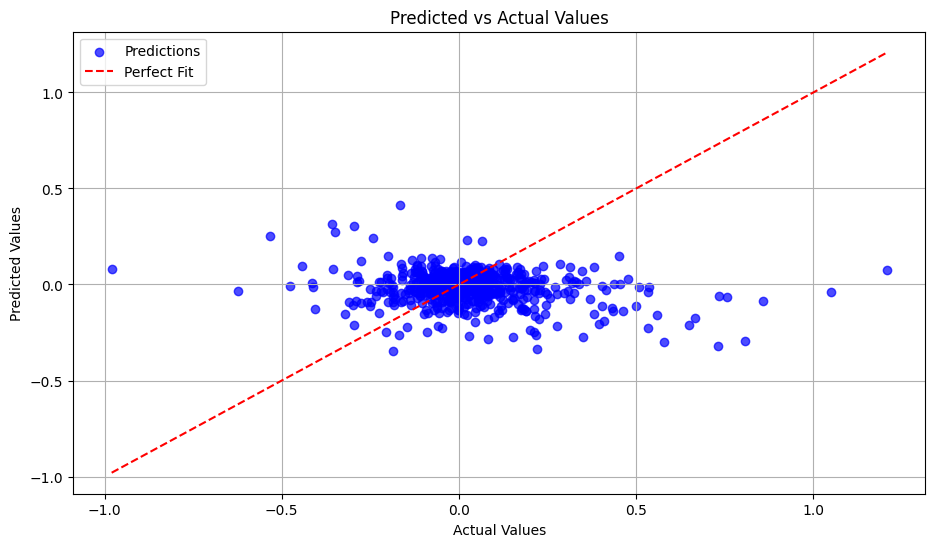

R²: -0.4646
MSE: 0.0509
MAE: 0.1443


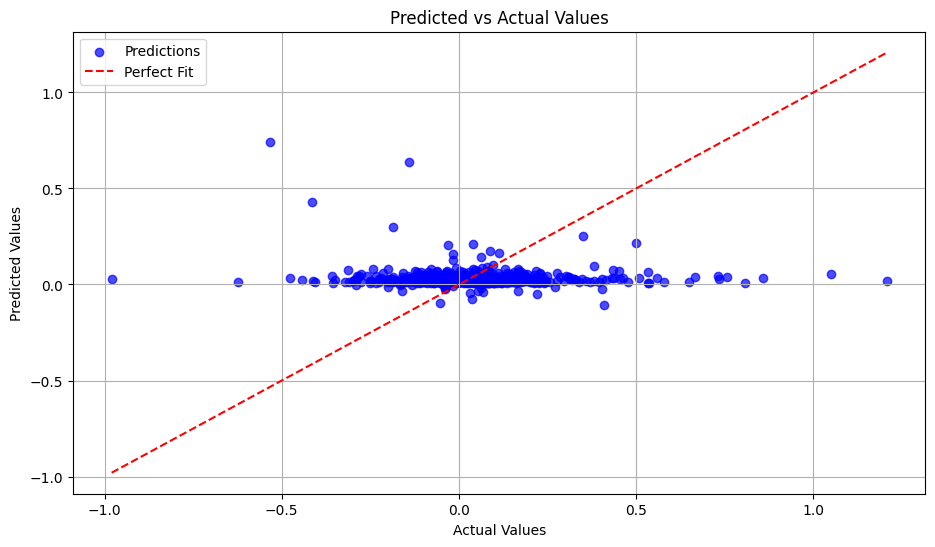

R²: -0.1222
MSE: 0.0390
MAE: 0.1253


In [181]:
if train_new_model:
    for y_pred in predictions:
        plt.figure(figsize=(11, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test.values.min(), y_test.values.max()], [y_test.values.min(), y_test.values.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f'R²: {r2:.4f}')
        print(f'MSE: {mse:.4f}')
        print(f'MAE: {mae:.4f}')

### Log test results

In [182]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        "iterations": iterations,
        'hidden_layer_sizes': [model.model.hidden_layer_sizes],
        'max_iter': model.model.max_iter,
        'n_iter_no_change': model.model.n_iter_no_change,
        'learning_rate': model.model.learning_rate,
        'learning_rate_init': model.model.learning_rate_init,
        'batch_size': model.model.batch_size,
        'tol': model.model.tol,
        'alpha': model.model.alpha,
        'shuffle': model.model.shuffle,
    })
    test_results.to_csv('../data/model_results/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../data/model_results/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

NameError: name 'iterations' is not defined

## Predictions on latest data

In [ ]:
best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.019355189464046


In [ ]:
df_raw = pd.read_csv('../data/model_results/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_9m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_9m + y_pred_1y) / 4
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '9m (%)': y_pred_9m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Industry
- PE
- Sector
Feature names seen at fit time, yet now missing:
- Amortization
- AmortizationOfIntangiblesIncomeStatement
- AverageDilutionEarnings
- BasicAverageShares
- BasicEPS
- ...


In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"Not enough data for this stock at this moment \n Try another", "", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['9m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'NVDA'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="9 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d6f7567b4876962a6e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
